In [1]:
import numpy as np
import torch
import sys
sys.path.append('../../mist-base/GW')
import gw150814_simulator as gs

class Simulator_Additive:
    def __init__(self, Nbins, sigma, bounds=5, fraction=None, 
                 sample_fraction=False, bkg=False, device='cpu', 
                 dtype=torch.float64, mode=None, bump = None,
                 specific_theta = None, frange = [None,None],
                 lock_amp = False, lock_mu=False, lock_sigma=False):
        """
        Args:
        - Nbins (int): Number of bins in the histogram.
        - sigma (float): Standard deviation of the Gaussian noise.
        - bounds (float): Bounds for the uniform distribution of the additive noise.
        - fraction (float): Fraction of bins to be perturbed by the additive noise. If None, just one bin is perturbed.
        - bkg (bool): If True, the simulator generates a bkground signal.
        - device (str): Device to run the tensors on.
        - dtype (torch.dtype): Data type of the tensors.
        - mode (str): white, complex or gw - simulation generation mode
        - bump (str or list): None, det or [a,m,s] - whether to generate a bump as mu and whether it is stochastic or not
        """
        self.mode = mode
        if self.mode == 'gw':
            default = gs.defaults
            default['posterior_samples_path'] = '../../mist-base/GW/GW150814_posterior_samples.npz'
            self.gw = gs.GW150814(settings=default)

            self.Nbins = len(self.gw.frequencies)
            

            self.frange = [20,1024] if (frange[0] == None) else frange
            self.mask = (self.gw.frequencies>=self.frange[0])&(self.gw.frequencies<self.frange[1])
            self.grid = self.gw.frequencies
            self.grid_chopped = self.grid[self.mask]
            self.psdnorm = torch.tensor(np.sqrt(self.gw.psd))
        else: 
            self.Nbins = Nbins
            self.grid = torch.linspace(0, self.Nbins, self.Nbins, device=device, dtype=dtype)

            self.frange = [0,self.Nbins] if (frange[0] == None) else frange
            self.mask = (self.grid>=self.frange[0])&(self.grid<self.frange[1])
            self.grid_chopped = self.grid[self.mask]

        self.device = device
        self.dtype = dtype
        self.sigma = sigma
        self.bounds = np.abs(bounds)
        self.bkg = bkg
        self.fraction = fraction
        self.sample_fraction = sample_fraction


        self.bump = bump

        self.lock_amp = lock_amp
        self.lock_mu = lock_mu
        self.lock_sigma = lock_sigma

        self.spec_theta = specific_theta

    ########### GW SETUP STUFF #################

    def _fd_noise(self,nsims):
        xshape = [nsims, len(self.grid)]
        white_noise_fd = (
            np.random.normal(size=xshape)
            + 1j * np.random.normal(size=xshape)
        ) / np.sqrt(2)
        prefactor = np.sqrt(self.gw.psd) / np.sqrt(2 * self.gw.delta_f)
        noise_fd = prefactor * white_noise_fd
        # noise_fd_filtered = noise_fd * self.gw.filter
        torch_mask = torch.as_tensor(self.mask)
        return (torch.tensor(np.abs(noise_fd))/self.psdnorm)[:,torch_mask]
    
    def _fd_theta_batched(self,nsims):
        choices = np.random.choice(self.gw.posterior_array.shape[0], size=nsims, replace=True)
        params_batch = self.gw.posterior_array[choices]
        return params_batch

    def _fd_waveform_batched(self, params_batch):
        theta_ripple_batch = jnp.array(params_batch[:, :8])
        ra_batch, dec_batch, psi_batch = params_batch[:, 8], params_batch[:, 9], params_batch[:, 10]
        batched_waveform = jax.vmap(self.gw.call_waveform)
        batched_detector_response = jax.vmap(
            self.gw.detector.fd_response,
            in_axes=(None, {'p': 0, 'c': 0}, {'ra': 0, 'dec': 0, 'psi': 0, 'gmst': None})
        )
        hp_batch, hc_batch = batched_waveform(theta_ripple_batch)
        wf_fd_batch = batched_detector_response(
            self.gw.frequencies,
            {"p": hp_batch, "c": hc_batch},
            {"ra": ra_batch, "dec": dec_batch, "psi": psi_batch, "gmst": self.gw.gmst},
        )
        wf_fd_block = torch.from_numpy(np.array(wf_fd_batch))
        torch_mask = torch.as_tensor(self.mask)
        return (torch.abs(wf_fd_block) / self.psdnorm)[:,torch_mask]
    
    ############### STOCHAISTIC GAUSSIAN SETUP STUFF ############

    def _gauss(self, x: torch.Tensor, m, amp, sigma) -> torch.Tensor:
        return amp * np.exp(-0.5 * ((x - m) / sigma) ** 2)
    
    def _gauss_theta_batched(self,nsims):
        theta_default = torch.Tensor([self.Nbins/2,3,self.Nbins/24]) if (self.spec_theta == None) else self.spec_theta
        theta_locked = theta_default*torch.ones(nsims, 3)
        if self.bump != 'stoch':
            return theta_locked
        else:
            norm = torch.tensor([self.Nbins/5,1,8])
            start = torch.tensor([self.Nbins/2, 3,self.Nbins/24])
            theta = torch.abs(torch.rand(nsims, 3, device=self.device, dtype=self.dtype) * norm + start)
            locks = torch.tensor([self.lock_mu, self.lock_amp, self.lock_sigma], device=self.device, dtype=torch.bool)
            output = torch.where(locks, theta_locked, theta)
            return output
    
    def _gauss_mu_batched(self,nsims,theta:torch.Tensor):
        # grid = torch.arange(self.Nbins).unsqueeze(0)*torch.ones([nsims,self.Nbins])
        grid = self.grid_chopped*torch.ones([nsims,len(self.grid_chopped)])
        mu = self._gauss(grid, theta[:,0].unsqueeze(-1), theta[:,1].unsqueeze(-1), theta[:,2].unsqueeze(-1))
        torch_mask = torch.as_tensor(self.mask)
        return (mu)[:,torch_mask]
    
    ######### GET COMMANDS ############

    def get_theta(self, Nsims: int) -> torch.Tensor:
        if self.mode == 'gw':
            return self._fd_theta_batched(nsims=Nsims)
        else:
            return self._gauss_theta_batched(nsims=Nsims)

    def get_mu(self, Theta: torch.Tensor) -> torch.Tensor:
        Nsims = Theta.shape[0]
        if self.mode == 'gw':
            return self._fd_waveform_batched(Theta)
        else:
            return self._gauss_mu_batched(Nsims, Theta)
    
    def get_noise_H0(self, Nsims):
        x_shape = (Nsims, len(self.grid_chopped))
        if self.mode == 'gw':
            return self._fd_noise(nsims=Nsims)
        elif self.mode == 'complex':
            noise = torch.complex(torch.randn(x_shape), torch.randn(x_shape))
            return torch.abs(noise).to(self.dtype)
        else:
            return (torch.randn(x_shape, device=self.device, dtype=self.dtype) * self.sigma).to(self.dtype)

    def get_x_H0(self, Nsims: int, mu: torch.Tensor = 0) -> torch.Tensor:
        return mu + self.get_noise_H0(Nsims=Nsims)

    def get_ni(self, x: torch.Tensor) -> torch.Tensor:
        if self.fraction is None:
            """Standard basis vectors"""
            batch_size, N_bins = x.shape
            ni = torch.zeros(batch_size, N_bins, device=self.device, dtype=self.dtype)
            indices = torch.randint(0, N_bins, (batch_size,), device=self.device)
            ni[torch.arange(batch_size), indices] = 1
        else:
            """Fraction of bins are distorted"""
            if self.sample_fraction:
                fr = np.random.uniform(0.01, self.fraction)
            else:   
                fr = self.fraction
            prob = fr
            random_vals = torch.rand_like(x)
            ni = (random_vals < prob).type(self.dtype)  # fr% chance
        return ni
    
    def get_epsilon(self, ni: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return (2 * self.bounds * torch.rand(x.shape, device=self.device, dtype=self.dtype) - self.bounds) * ni # returns on [-self.bounds, self.bounds)
    
    def get_x_Hi(self, epsilon: torch.Tensor, ni: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return x + epsilon * ni
    
    def _sample(self, Nsims: int) -> dict:
        sample = {}
        x_shape = (Nsims, len(self.grid_chopped))
        if self.bkg:
            theta = self.get_theta(Nsims)
            mu = self.get_mu(theta)
            sample['theta'] = theta
            sample['mu'] = mu
            x0 = self.get_x_H0(Nsims, mu)
        else:
            mu = torch.zeros(x_shape).to(dtype=self.dtype)
            sample['mu'] = mu.to(dtype=self.dtype)
            x0 = self.get_x_H0(Nsims, 0).to(dtype=self.dtype)
        ni = self.get_ni(x0).to(dtype=self.dtype)
        epsilon = self.get_epsilon(ni, x0).to(dtype=self.dtype)
        xi = self.get_x_Hi(epsilon, ni, x0).to(dtype=self.dtype)
        
        sample.update({'x0': x0,'epsilon': epsilon, 'ni': ni, 'xi': xi})
        return sample
    
    def _resample(self, sample: dict) -> dict:
        Nsims = sample['x0'].shape[0] if sample['x0'].ndim == 2 else 1
        if self.bkg:
            sample['x0'] = self.get_x_H0(Nsims, sample['mu'])
        else:  
            sample['x0'] = self.get_x_H0(Nsims, 0)
        sample['ni'] = self.get_ni(sample['x0'])
        sample['epsilon'] = self.get_epsilon(sample['ni'], sample['x0'])
        sample['xi'] = self.get_x_Hi(sample['epsilon'], sample['ni'], sample['x0'])
        return sample
    
    def sample(self, Nsims: int = 1) -> dict:
        sample = self._sample(Nsims)
        return sample

In [2]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

# from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [3]:
simulator = Simulator_Additive(100,1,5,0.02,mode='gw', bkg=True)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


In [4]:

N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
data_bin_H0 = []

for _ in tqdm(range(N_batch)):
    dummy = np.ones([124,len(simulator.grid)])*simulator.grid
    mc_samples = simulator._fd_noise(124)
    data_bin_H0.append(mc_samples)
    
data_bin_H0 = np.concatenate(data_bin_H0)


### Start by ascertaining the data distribution ###
from scipy.stats import norm
def get_quantiles(indata, nsig:int, sigma_key=False):
    data = np.sort(indata)
    sigmas = np.arange(-nsig,nsig+1,1)
    indices = (len(data)*norm.cdf(sigmas)).astype(int)
    if not sigma_key:
        return data[indices]
    else:
        return np.array([data[indices],sigmas])
    
alldata = data_bin_H0.flatten()
mean = np.mean(alldata)
quantiles = get_quantiles(alldata, 3)
quantiles_long = get_quantiles(alldata,5)

quantiles = np.array([0.05199686, 0.2145543,  0.58780088, 1.17737921, 1.91882754,
 2.75067576, 3.63463655])

quantiles_long = np.array([7.11978022e-04, 7.96148769e-03, 5.19968566e-02, 2.14554300e-01,
 5.87800876e-01, 1.17737921e+00, 1.91882754e+00, 2.75067576e+00,
 3.63463655e+00, 4.55164698e+00, 5.49045819e+00])

100%|██████████| 488/488 [00:12<00:00, 39.64it/s]


In [5]:
# dummy = np.ones([124,len(simulator.grid)])*simulator.grid
# a = simulator._fd_noise(124)
# pb = simulator._fd_theta_batched(124)
# b = simulator._fd_waveform_batched(pb)

# fig,ax = pf.create_plot()
# ax2 = fig.add_axes((1,0,0.3,1))
# plt.setp(ax2.get_yticklabels(), visible=False)

# ax.plot(simulator.grid,a[0], color='#ff004f', lw=0.5, alpha=1)

# ax.set_ylabel(r'$\tilde{d}_w(f)$')
# ax.set_xlabel(r'$f$')
# ax.set_xlim(1, 1024)

# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='#ff004f')
# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='black', histtype='step')
# ax2.set_xticks([0.25,0.50])
# ax2.set_xlim([0,0.69])

# for i,q in enumerate(quantiles_long):
#     extra = np.linspace(-100,2148, 100)
#     ax.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)
#     ax2.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)

# ax.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)
# ax2.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)


# pf.fix_plot([ax,ax2])

In [6]:
# dummy = np.ones([124,len(simulator.grid)])*simulator.grid
# a = simulator._fd_noise(124)
# pb = simulator._fd_theta_batched(124)
# b = simulator._fd_waveform_batched(pb)

# fig,ax = pf.create_plot()
# ax2 = fig.add_axes((1,0,0.3,1), sharey=ax)
# plt.setp(ax2.get_yticklabels(), visible=False)

# ax.plot(simulator.grid,a[0]+b[0], color='#ff004f', lw=0.5, alpha=1)

# ax.set_ylabel(r'$\tilde{d}_w(f)$')
# ax.set_xlabel(r'$f$')
# ax.set_xlim(20, 1024)
# ax.set_ylim(0,6)

# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='#ff004f')
# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='black', histtype='step')
# ax2.set_xticks([0.25,0.50])
# ax2.set_xlim([0,0.69])

# for i,q in enumerate(quantiles_long):
#     extra = np.linspace(-100,2148, 100)
#     ax.fill_between(simulator.grid, quantiles_long[i]+b[0], quantiles_long[-i]+b[0],  color='#b0b0b0', alpha=0.15, zorder=-10)
#     ax2.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)

# ax.plot(simulator.grid, quantiles[3]+b[0], lw=3, c="#7f7f7f", zorder=-10)
# ax2.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)


# pf.fix_plot([ax,ax2])

/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_75972/128859692.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_75972/128859692.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


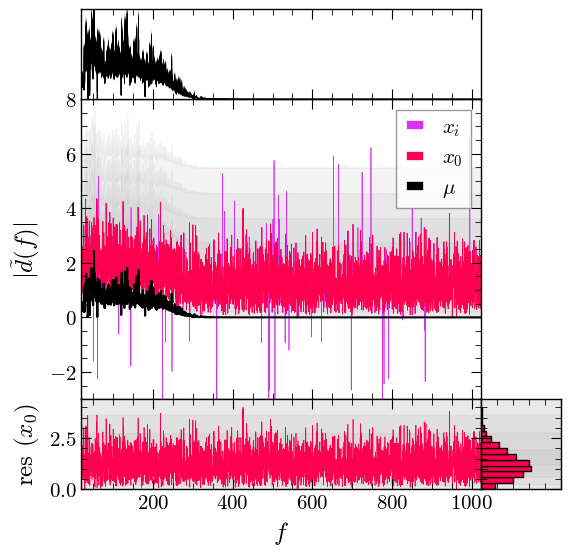

In [9]:
samples = simulator.sample(124)  
obs = simulator.sample(1)
# simulator.get_theta(100)

test = simulator.sample(1)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax4 = fig.add_axes((0,1,1,0.3), sharex=ax1)
plt.setp(ax4.get_xticklabels(), visible=False)

ax1.plot(simulator.grid_chopped,test['xi'][0], label=r'$x_i$', color="#d931f3", lw=0.5)
ax1.plot(simulator.grid_chopped,test['x0'][0], label=r'$x_0$', color='#ff004f', lw=0.5)
ax1.plot(simulator.grid_chopped,test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([-3,8])
ax1.legend(loc='upper right')
ax1.set_xlim(20, 1024)


resd = test['x0'][0]-test['mu'][0]
ax2.plot(simulator.grid_chopped,resd, color='#ff004f', lw=0.5)
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
for i in range(1,6):
    ax1.fill_between(simulator.grid_chopped, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.15)
    ax2.fill_between(simulator.grid_chopped, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15)
    ax3.fill_between(simulator.grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

for i in range(100):
    ax4.plot(simulator.grid_chopped,simulator.sample(1)['mu'][0], lw=0.5, color='black', alpha=0.05)

ax4.set_yticks([])
ax4.set_ylim([0,2])
pf.fix_plot([ax1,ax2, ax3,ax4])
plt.tight_layout()

plt.tight_layout()


In [ ]:
obs

{'mu': tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 'x0': tensor([[0.9975, 2.3634, 0.5018,  ..., 2.2613, 0.4140, 0.5706]],
        dtype=torch.float64),
 'epsilon': tensor([[0., -0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 'ni': tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 'xi': tensor([[0.9975, 2.3634, 0.5018,  ..., 2.2613, 0.4140, 0.5706]],
        dtype=torch.float64)}

In [8]:
import jax
import jax.numpy as jnp